# Pengambilan Data

In [2]:
from tweepy import API 
from tweepy import Cursor
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream

In [3]:
import twitter_credentials
import pandas as pd
import numpy as np
from textblob import TextBlob
import re
import string
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# # # # TWITTER CLIENT # # # #
class TwitterClient():
    def __init__(self, twitter_user=None):
        self.auth = TwitterAuthenticator().authenticate_twitter_app()
        self.twitter_client = API(self.auth)

        self.twitter_user = twitter_user

    def get_twitter_client_api(self):
        return self.twitter_client

In [4]:
# # # # TWITTER AUTHENTICATER # # # #
class TwitterAuthenticator():

    def authenticate_twitter_app(self):
        auth = OAuthHandler(twitter_credentials.CONSUMER_KEY, twitter_credentials.CONSUMER_SECRET)
        auth.set_access_token(twitter_credentials.ACCESS_TOKEN, twitter_credentials.ACCESS_TOKEN_SECRET)
        return auth

In [5]:
# # # # TWITTER STREAMER # # # #
class TwitterStreamer():
    """
    Class for streaming and processing live tweets.
    """
    def __init__(self):
        self.twitter_autenticator = TwitterAuthenticator()    

    def stream_tweets(self, fetched_tweets_filename, hash_tag_list):
        # This handles Twitter authetification and the connection to Twitter Streaming API
        listener = TwitterListener(fetched_tweets_filename)
        auth = self.twitter_autenticator.authenticate_twitter_app() 
        stream = Stream(auth, listener)

        # This line filter Twitter Streams to capture data by the keywords: 
        stream.filter(track=hash_tag_list)

In [6]:
# # # # TWITTER STREAM LISTENER # # # #
class TwitterListener(StreamListener):
    """
    This is a basic listener that just prints received tweets to stdout.
    """
      
    def __init__(self, fetched_tweets_filename):
        self.fetched_tweets_filename = fetched_tweets_filename

    def on_data(self, data):
        try:
            print(data)
            with open(self.fetched_tweets_filename, 'a') as tf:
                       tf.write(data)
            return True
        except BaseException as e:
            print("Error on_data %s" % str(e))
        return True
          
    def on_error(self, status):
        if status == 420:
            # Returning False on_data method in case rate limit occurs.
            return False
        print(status)

In [7]:
 class TweetAnalyzer():
    """
    Functionality for analyzing and categorizing content from tweets.
    """
         
    def clean_tweet(self, tweet):
    
        return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w +:\/\/ \S +)", " ", tweet).split())
    
    def analyze_sentiment(self, tweet):
        analysis = TextBlob(self.clean_tweet(tweet))
        # analysis = analysis.translate(from_lang = 'in',to='en')

        if analysis.sentiment.polarity > 0:
            return "Positif"
        elif analysis.sentiment.polarity == 0:
            return "Netral"
        else:
            return "Negatif"
        
    def tweets_to_data_frame(self, tweets):
        df = pd.DataFrame(data=[tweet.text for tweet in tweets], columns=['tweets'])
        
        df['id'] = np.array([tweet.id_str for tweet in tweets])
        df['date'] = np.array([tweet.created_at for tweet in tweets])
        df['source'] = np.array([tweet.source for tweet in tweets])
        df['lang'] = np.array([tweet.lang for tweet in tweets])
        df['place'] = np.array([tweet.place for tweet in tweets ])
        

        return df

In [12]:
if __name__ == '__main__':

    twitter_client = TwitterClient()
    tweet_analyzer = TweetAnalyzer()
    keyword = ["bitcoin"]
    api = twitter_client.get_twitter_client_api()
    tweets = api.search(keyword, count=100, lang = 'en')

    df = tweet_analyzer.tweets_to_data_frame(tweets)
    df['sentiment'] = np.array([tweet_analyzer.analyze_sentiment(tweet) for tweet in df['tweets']])

    print(df)

                                               tweets                   id  \
0   #corona eaten not only lives but also entire #...  1238272176886665219   
1   RT @B_naira01: #BitcoinCash Rt and send me a D...  1238272176605855747   
2   #BTC WILL NOT GO BELOW 9k #Bitcoin https://t.c...  1238272174785470465   
3   Anyone need a kidney? #BTC #Bitcoin #Bitcoin20...  1238272170842886145   
4   Almost $700 Mln Bitcoin (BTC) Positions Liquid...  1238272170460999680   
..                                                ...                  ...   
95  RT @MichellePhan: All my friends have been hit...  1238271912620494853   
96  RT @RonnieMoas: $BTC #bitcoin halving ... $10,...  1238271910368219143   
97  @scottmelker It’s #bitcoin.  There are no fund...  1238271909910867969   
98  +3.23%↗️price up probability 65%\n601 #BTC is ...  1238271909059534848   
99  RT @quantumflux88: YOU THINK A FUCKING FLU MAK...  1238271907884978176   

                  date               source lang place sentimen

# Preproses

In [13]:
def remove_punct(text):
  
    #hapus simbol
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',text)
    text = re.sub('rt @[^\s]+',' ', text)
    text = re.sub('@[^\s]+',' ',text)
    text = re.sub(r'[^\x00-\x7F]+',' ', text)
    #Remove additional white spaces
    text = re.sub('[\s]+', ' ', text)
    text = re.sub(r'#([^\s]+)', r'\1', text)
    #trim
    text = text.strip('\'"')
    text  = "".join([char for char in text if char not in string.punctuation])
    #text = re.sub('[0-9]+', '', text)

    return text

df['tweet_bersih'] = df['tweets'].apply(lambda x: remove_punct(x.lower()))

In [14]:
#--- REMOVE DUPLICATES
df = df.drop_duplicates(['tweet_bersih'])
df

,tweets,id,date,source,lang,place,sentiment,tweet_bersih
0,#corona eaten not only lives but also entire #...,1238272176886665219,2020-03-13 01:14:27,Twitter Web App,en,None,Netral,corona eaten not only lives but also entire ec...
1,RT @B_naira01: #BitcoinCash Rt and send me a D...,1238272176605855747,2020-03-13 01:14:27,Twitter for iPhone,en,None,Positif,bitcoincash rt and send me a dm now to sell o...
2,#BTC WILL NOT GO BELOW 9k #Bitcoin https://t.c...,1238272174785470465,2020-03-13 01:14:27,Twitter for iPhone,en,None,Netral,btc will not go below 9k bitcoin
3,Anyone need a kidney? #BTC #Bitcoin #Bitcoin20...,1238272170842886145,2020-03-13 01:14:26,Twitter Web App,en,None,Netral,anyone need a kidney btc bitcoin bitcoin2020 b...
4,Almost $700 Mln Bitcoin (BTC) Positions Liquid...,1238272170460999680,2020-03-13 01:14:26,Twitter for Android,en,None,Netral,almost 700 mln bitcoin btc positions liquidate...
...,...,...,...,...,...,...,...,...
94,RT @XVGWhaleReal: I was feeling sick and depre...,1238271915006943233,2020-03-13 01:13:25,Twitter for iPhone,en,None,Positif,i was feeling sick and depressed this morning...
95,RT @MichellePhan: All my friends have been hit...,1238271912620494853,2020-03-13 01:13:24,Twitter for iPhone,en,None,Netral,all my friends have been hitting me up asking...
96,"RT @RonnieMoas: $BTC #bitcoin halving ... $10,...",1238271910368219143,2020-03-13 01:13:24,Twitter Web App,en,None,Netral,btc bitcoin halving 10000 to 5000 in three w...
97,@scottmelker It’s #bitcoin. There are no fund...,1238271909910867969,2020-03-13 01:13:23,Twitter for iPhone,en,None,Netral,it s bitcoin there are no fundamental reasons...


In [15]:
df.to_excel("Data Tanggal 13 pagi (bitcoin).xlsx")
df.to_csv("Data Tanggal 13 pagi (bitcoin).csv")

# Visualisasi Data

In [4]:
df = pd.read_excel('Data Tanggal 9 siang (cryptocurrency).xlsx',header=0,encoding = 'unicode_escape', index_col=0)
df.count

<bound method DataFrame.count of                                                tweets                   id  \
0   RT @Main_Value: For the #chart lovers out ther...  1236904264028622848   
1   Over $26 billion wiped off cryptocurrency mark...  1236904213503856640   
2   Drugs by drone and mother mentors: how health ...  1236904180251533312   
3   RT @Cryptoskulll: 🚨 10$  #BTC &amp; 15.000 #Ci...  1236904175054852096   
4   RT @IXX_Official: Claim your $10 no deposit #t...  1236904171045076992   
..                                                ...                  ...   
94  @BrendanEich @dpinsen @Schuldensuehner It seem...  1236901293295190019   
95  RT @FidesExchange: Trade HyperStake (HYP) with...  1236901265872949248   
96  The MOVIECASH coin from the CINEMADROM! https:...  1236901200718704642   
98  Wuxian Ico Review : A Hybrid Cryptocurrency Ga...  1236901131009261569   
99  How to clean the dust in your Coinbase Pro and...  1236901125120577536   

                  date        

In [5]:
df = df.drop_duplicates(['tweet_bersih'])

In [6]:
df_positif = df[df['sentiment'] == 'Positif']
df_negatif = df[df['sentiment'] == 'Negatif']
df_netral = df[df['sentiment'] == 'Netral']
df_negatif

,tweets,id,date,source,lang,place,sentiment,tweet_bersih
94,@BrendanEich @dpinsen @Schuldensuehner It seem...,1236901293295190019,2020-03-09 06:27:03,Twitter for iPhone,en,NaN,Negatif,it seems it all comes down to stimulating the...


In [7]:
sentimen_count = df['sentiment'].value_counts()
sentimen_count

Positif    45
Netral     33
Negatif     1
Name: sentiment, dtype: int64

In [8]:
from wordcloud import WordCloud
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator
from stop_words import get_stop_words

stopwords = get_stop_words('english')
stopwords_add = list()
stopwords_add = input("Apa?")
stopwords += stopwords_add

Apa?cryptocurrency


In [9]:
words_positif = ' '.join(df_positif['tweet_bersih'])
words_negatif = ' '.join(df_negatif['tweet_bersih'])
words_netral = ' '.join(df_netral['tweet_bersih'])

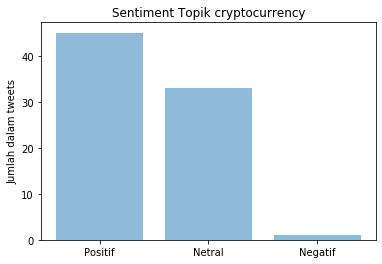

In [10]:
objects = sentimen_count.index
y_pos = np.arange(len(objects))
performance = sentimen_count
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Jumlah dalam tweets')
plt.title('Sentiment Topik '+ stopwords_add)
 
plt.show()

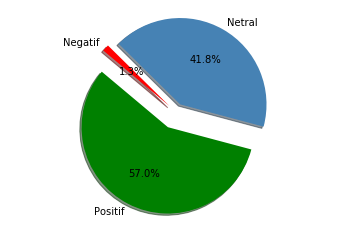

In [12]:
labels = sentimen_count.index
sizes = sentimen_count
colors = ['green', 'steelblue', 'red']
explode = (0.2, 0.1, 0.1)  # explode 1st slice
 
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
 
plt.axis('equal')
plt.show()

In [30]:
mask = np.array(Image.open("shape.png"))
wordcloud = WordCloud(stopwords = stopwords, background_color='white', height = 2000, width = 2000, max_words = 50, font_path='lucidasansdemibold.ttf', prefer_horizontal=0.70, colormap='copper', mask=mask).generate(words_positif)

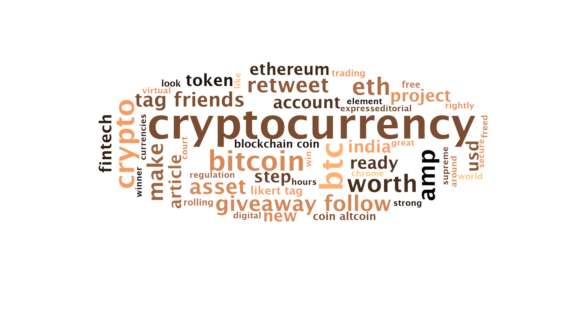

In [31]:
plt.figure(figsize=[10,10])
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis('off')
plt.ion()
plt.show()

In [61]:
# Save the image
wordcloud.to_file("wordcloud_positif.png")

In [32]:
wordcloud = WordCloud(stopwords = stopwords, background_color='white', height = 2000, width = 2000,
                      max_words = 50, font_path='lucidasansdemibold.ttf', prefer_horizontal=0.70, colormap='copper', mask=mask).generate(words_negatif)

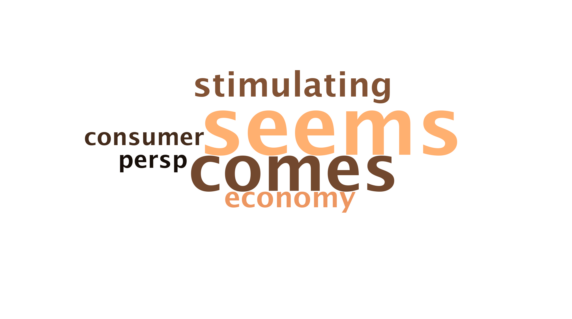

In [33]:
plt.figure(figsize=[10,10])
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis('off')
plt.ion()
plt.show()

In [65]:
# Save the image
wordcloud.to_file("wordcloud_negatif.png")

In [34]:
wordcloud = WordCloud(stopwords = stopwords, background_color='white', height = 2000, width = 2000,
                      max_words = 50, font_path='lucidasansdemibold.ttf', prefer_horizontal=0.70, colormap='copper', mask=mask).generate(words_netral)

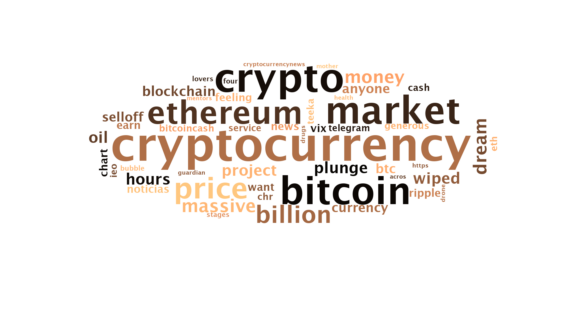

In [35]:
plt.figure(figsize=[10,10])
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis('off')
plt.ion()
plt.show()

In [32]:
# Save the image
wordcloud.to_file("wordcloud_netral.png")